In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx

In [2]:
df = pd.read_csv('exported_data/normalized_9.df')

In [3]:
datasets = []

for idx, val in df['datasets'].apply(lambda x: sorted(eval(x))).items():
    datasets.extend(val)
    
datasets = list(set(datasets))
print(datasets)

['imdb/test/embeddings.npy', 'clinc_oos;plus/validation/embeddings.npy', 'dennlinger/wiki-paragraphs/test/embeddings.npy', 'ag_news/test/embeddings.npy', 'rotten_tomatoes/validation/embeddings.npy', 'mteb/biosses-sts/test/embeddings.npy', 'tweet_eval;emoji/train/embeddings.npy', 'paws-x;en/test/embeddings.npy', 'paws-x;en/train/embeddings.npy', 'snli/validation/embeddings.npy', 'rotten_tomatoes/train/embeddings.npy', 'tweet_eval;emotion/validation/embeddings.npy', 'dair-ai/emotion/test/embeddings.npy', 'tweet_eval;emotion/train/embeddings.npy', 'tweet_eval;sentiment/test/embeddings.npy', 'imdb/train/embeddings.npy', 'mteb/sts13-sts/test/embeddings.npy', 'snli/test/embeddings.npy', 'sst2/validation/embeddings.npy', 'mteb/sickr-sts/test/embeddings.npy', 'mteb/amazon_polarity/test/embeddings.npy', 'cnn_dailymail/test/embeddings.npy', 'imdb/unsupervised/embeddings.npy', 'mteb/sts14-sts/test/embeddings.npy', 'clinc_oos;plus/test/embeddings.npy', 'tweet_eval;sentiment/validation/embeddings.n

In [4]:
df.head()

,Unnamed: 0,id,date,model_1,model_2,d_1,d_2,dataset_filter,datasets,I(X_1->X_2),...,cond_modes,marg_modes,use_tanh,init_std,ff_residual_connection,ff_activation,ff_layer_norm,ff_layers,ff_dim_hidden,margin_lr
0,0,b71f81f2-ebf5-4e3b-9c5d-f726c7bec636,2024-04-05 21:51:19,../output/sentence-transformers/allenai-specter,../output/sentence-transformers/sentence-t5-xl,768,768,NaN,"['ag_news/test/embeddings.npy', 'snli/test/emb...",202.413983,...,8,8,True,0.01,False,relu,True,2,0,0.0001
1,0,629bf0d9-6cbe-4fc5-a1d5-f0d3298e7906,2024-04-05 20:28:33,../output/sentence-transformers/average_word_e...,../output/jinaai/jina-embedding-s-en-v1,300,512,NaN,"['rotten_tomatoes/test/embeddings.npy', 'paws-...",NaN,...,8,8,True,0.01,False,relu,True,2,0,0.0001
2,0,f0dcd884-c438-419a-a7ee-8593b33eacd4,2024-04-05 21:25:30,../output/princeton-nlp/sup-simcse-bert-base-u...,../output/intfloat/multilingual-e5-small,768,384,NaN,"['ag_news/train/embeddings.npy', 'ag_news/test...",115.984275,...,8,8,True,0.01,False,relu,True,2,0,0.0001
3,0,0ef829a4-1f2a-4d91-a59c-4383f6fe9b47,2024-04-05 16:14:55,../output/sentence-transformers/all-distilrobe...,../output/sentence-transformers/msmarco-bert-c...,768,768,NaN,['dennlinger/wiki-paragraphs/validation/embedd...,274.612059,...,8,8,True,0.01,False,relu,True,2,0,0.0001
4,0,8c1c57e1-1b13-4d37-bceb-2d3994e9ca3f,2024-04-05 20:12:51,../output/sentence-transformers/sentence-t5-xl,../output/google/gemma-7b,768,3072,NaN,"['mteb/amazon_polarity/test/embeddings.npy', '...",1678.095521,...,8,8,True,0.01,False,relu,True,2,0,0.0001


In [5]:
df['I(X_1->X_2)/H(X_2)'] = df['I(X_1->X_2)'] / df['H(X_2)']
df['I(X_1->X_2)/d_1'] = df['I(X_1->X_2)'] / df['d_1']
df['I(X_1->X_2)/d_2'] = df['I(X_1->X_2)'] / df['d_2']

df['model_1'] = df['model_1'].apply(lambda x: "/".join(x.split('/')[-2:]))
df['model_2'] = df['model_2'].apply(lambda x: "/".join(x.split('/')[-2:]))




In [6]:
df = df.groupby(['model_1', 'model_2']).first().reset_index()

In [7]:

df = df[~(df['model_1'] == "jinaai/jina-embedding-s-en-v1")]
df = df[~(df['model_2'] == "jinaai/jina-embedding-s-en-v1")]

In [12]:
sns.set_style("whitegrid")
METRIC = 'I(X_1->X_2)/d_2'
# METRIC = 'I(X_1->X_2)/H(X_2)'
# METRIC = 'I(X_1->X_2)'
from matplotlib import patheffects

cmap =sns.color_palette("coolwarm", as_cmap=True)


table = df
table = table[["model_1", "model_2", METRIC]].pivot("model_1", "model_2",METRIC).fillna(0)

# count number of 0 per row
n_0 = table.apply(lambda x: x[x == 0].count(), axis=1)

# count number of 0 per column
n_0_col = table.apply(lambda x: x[x == 0].count(), axis=0)

# remove rows with more than 50% of 0
# table = table[n_0 < table.shape[1] // 2]

# remove columns with more than 50% of 0
# table = table.loc[:, n_0_col < table.shape[0] // 2]

# make square
table = table.loc[table.index.intersection(table.columns)]



# remove lines with only 0

/tmp/ipykernel_4408/61322320.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = table[["model_1", "model_2", METRIC]].pivot("model_1", "model_2",METRIC).fillna(0)


In [13]:
table

model_2,BAAI/bge-base-en-v1.5,HuggingFaceM4/tiny-random-LlamaForCausalLM,NousResearch/Llama-2-7b-hf,SmartComponents/bge-micro-v2,TaylorAI/gte-tiny,WhereIsAI/UAE-Large-V1,avsolatorio/GIST-Embedding-v0,google/gemma-7b,google/gemma-7b-it,infgrad/stella-base-en-v2,...,sentence-transformers/average_word_embeddings_glove.6B.300d,sentence-transformers/average_word_embeddings_komninos,sentence-transformers/gtr-t5-base,sentence-transformers/gtr-t5-large,sentence-transformers/gtr-t5-xl,sentence-transformers/msmarco-bert-co-condensor,sentence-transformers/sentence-t5-large,sentence-transformers/sentence-t5-xl,thenlper/gte-base,thenlper/gte-large
BAAI/bge-base-en-v1.5,1.418037,0.000000,0.000000,0.411306,0.438430,0.000000,0.000000,0.541448,0.537680,0.960987,...,0.420926,0.382806,0.387189,0.371127,0.368101,0.434270,0.464824,0.423478,0.000000,0.000000
HuggingFaceM4/tiny-random-LlamaForCausalLM,0.000000,1.126319,0.067361,0.000000,0.000000,0.000000,0.000000,0.055332,0.048695,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.046092,0.000000,0.000000,0.000000,0.000000,0.000000
NousResearch/Llama-2-7b-hf,0.000000,0.000000,1.099669,0.000000,0.000000,0.000000,0.000000,0.715465,0.692570,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SmartComponents/bge-micro-v2,0.402953,0.000000,0.000000,1.432337,0.775080,0.000000,0.000000,0.511059,0.512165,0.495593,...,0.431515,0.392996,0.339681,0.336407,0.332281,0.371503,0.390710,0.358045,0.000000,0.000000
TaylorAI/gte-tiny,0.413414,0.000000,0.000000,0.762342,1.439227,0.000000,0.000000,0.519922,0.521450,0.507754,...,0.416655,0.377915,0.344648,0.339524,0.326023,0.368052,0.406305,0.371283,0.000000,0.000000
WhereIsAI/UAE-Large-V1,0.000000,0.000000,0.000000,0.000000,0.000000,1.423723,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
avsolatorio/GIST-Embedding-v0,0.000000,0.000000,0.000000,0.425652,0.431961,0.000000,1.443215,0.546405,0.554503,0.000000,...,0.415570,0.375786,0.396865,0.385165,0.358350,0.437873,0.466707,0.440530,1.167234,0.516724
google/gemma-7b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.131609,0.716919,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
google/gemma-7b-it,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.747930,1.077446,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
infgrad/stella-base-en-v2,0.947137,0.000000,0.000000,0.440524,0.463942,0.000000,0.000000,0.545050,0.542672,1.412584,...,0.448603,0.411894,0.426691,0.409920,0.400908,0.466209,0.491142,0.462448,0.000000,0.000000


In [14]:
def sanitize_metric_name(metric):
    return metric.replace('/', '_').replace(' ', '_').replace('(', '').replace(')', '').replace('->', 'to').replace('(', '').replace(')', '')


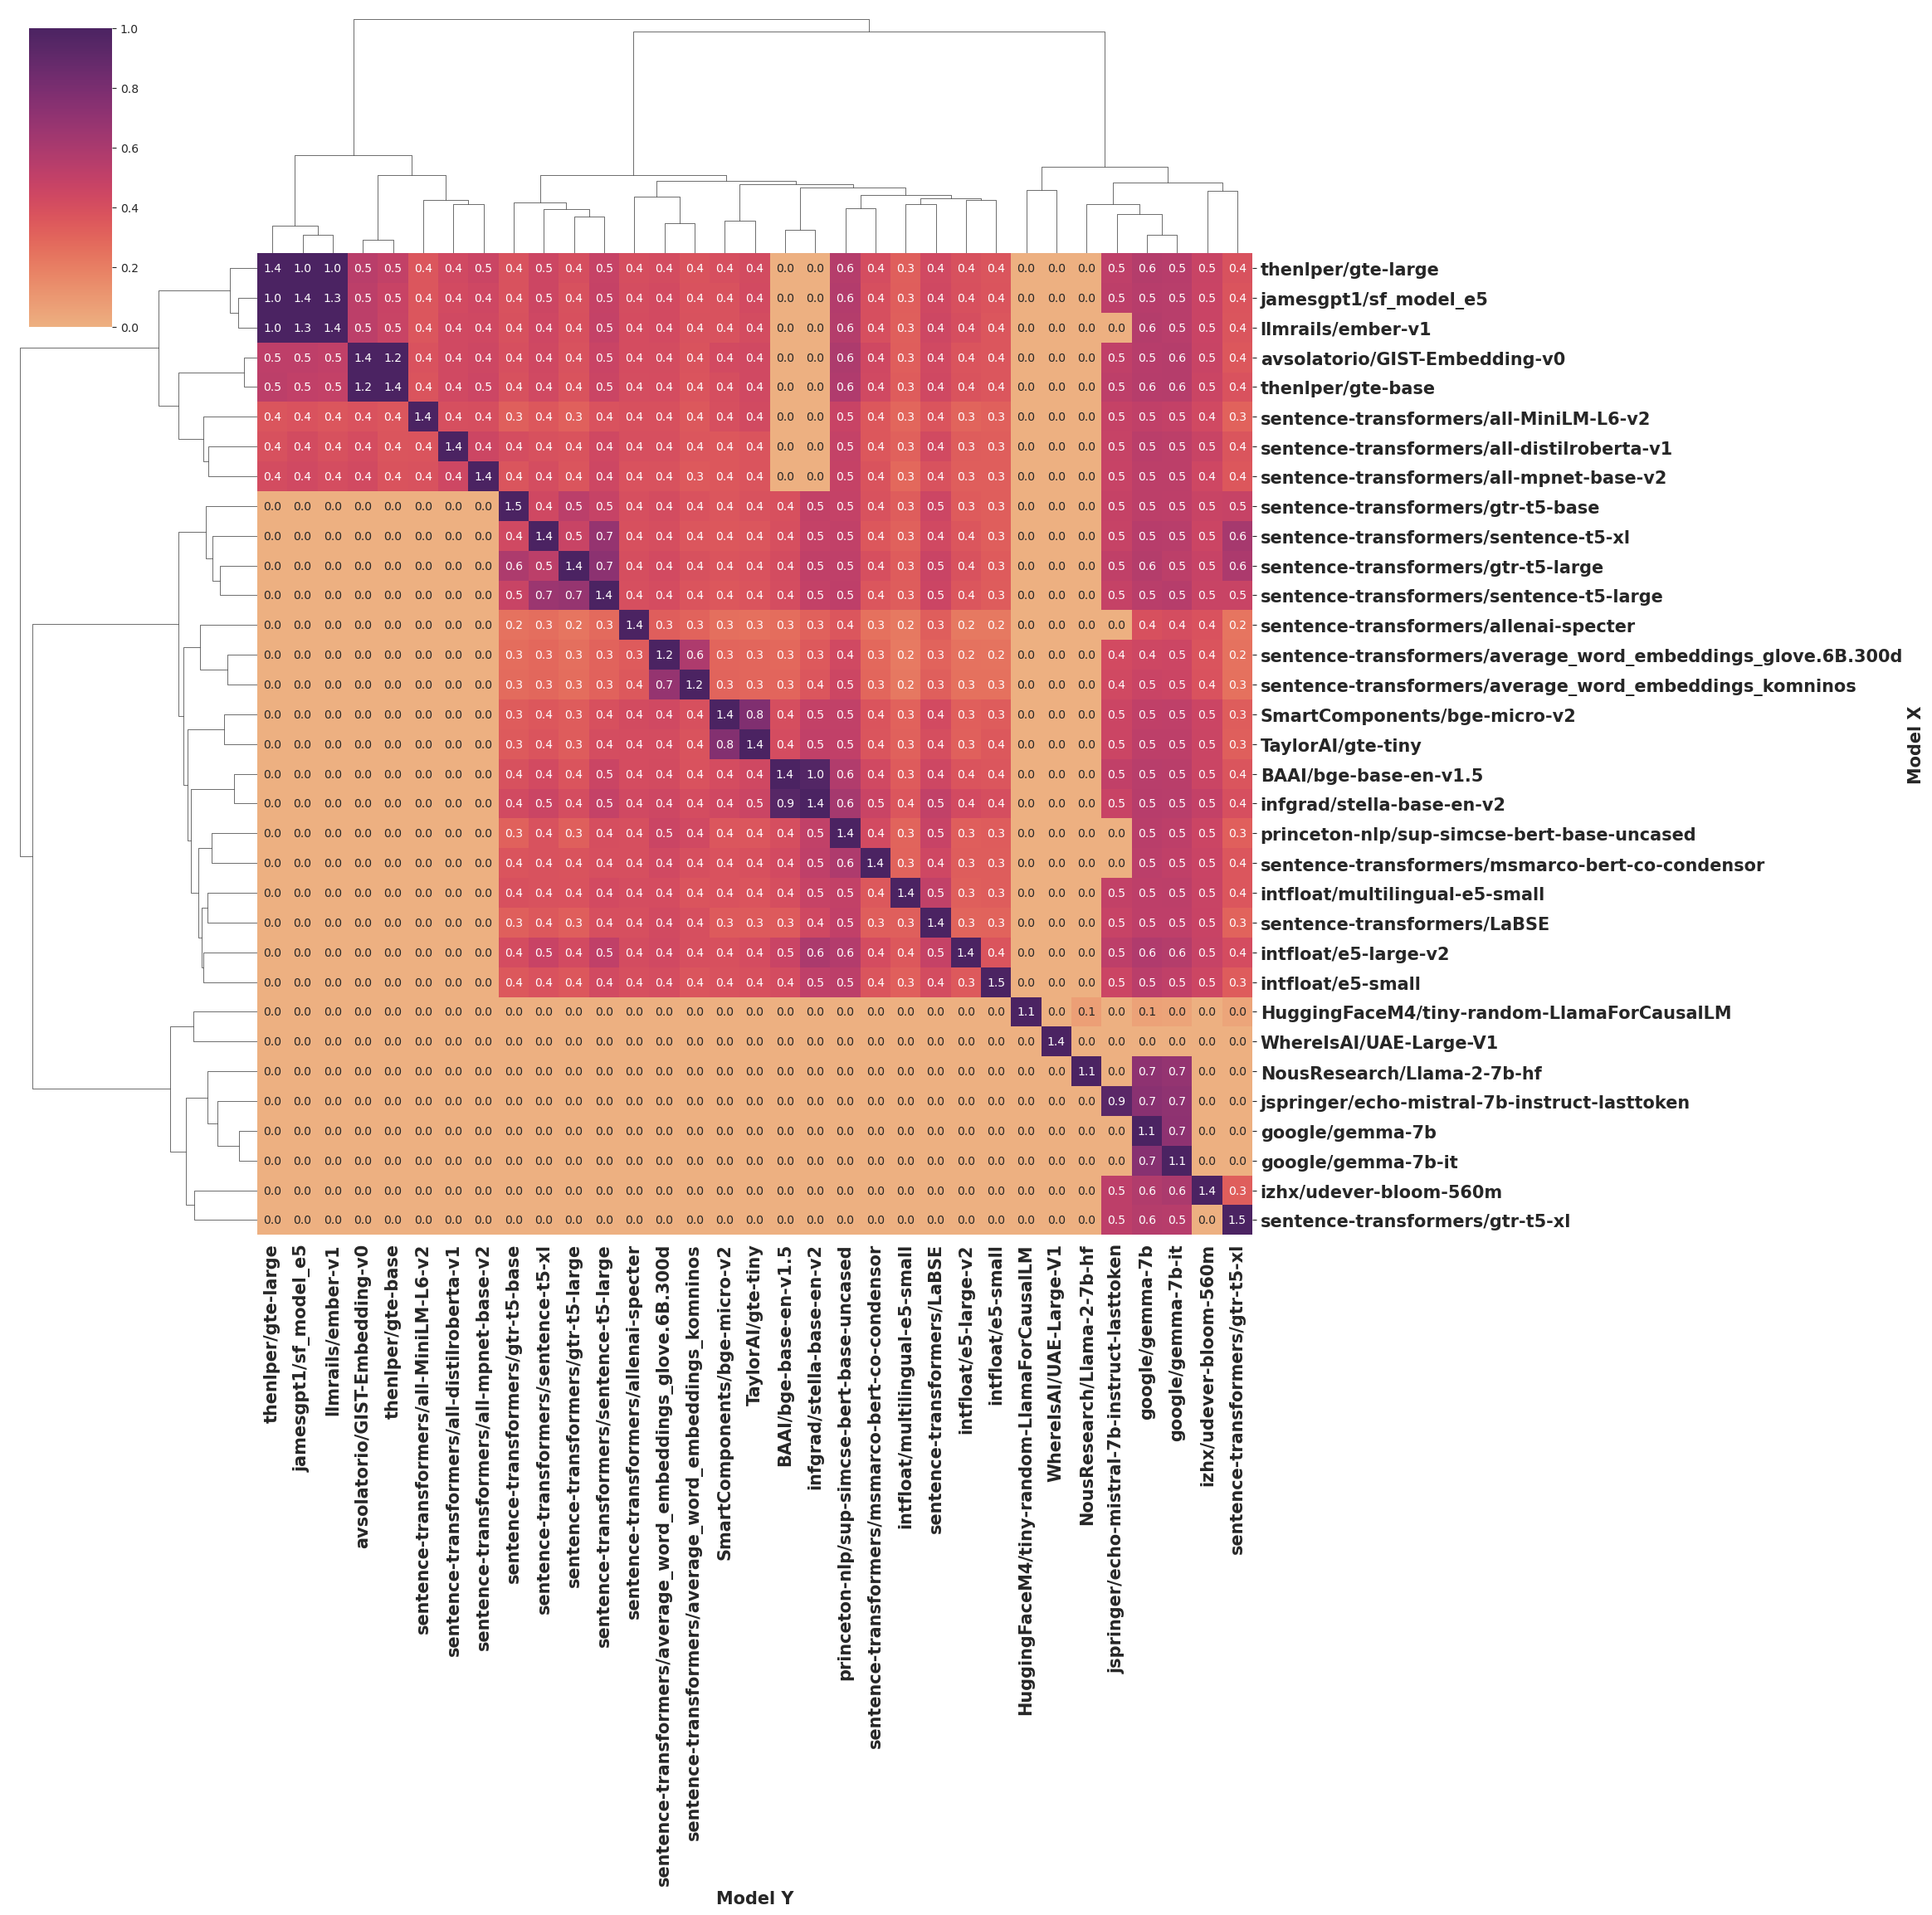

In [15]:
from scipy.cluster.hierarchy import linkage
link = linkage(table, method="ward")

cluster = sns.clustermap(table, row_linkage=link, col_linkage=link, figsize=(20, 20), cmap='flare', annot=True, fmt=".1f", vmax=1)

# make labels bigger and bold and rename in model X and model Y
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=15, fontweight='bold')
cluster.ax_heatmap.set_yticklabels(cluster.ax_heatmap.get_yticklabels(), fontsize=15, fontweight='bold')
cluster.ax_heatmap.set_xlabel("Model Y", fontsize=15, fontweight='bold')
cluster.ax_heatmap.set_ylabel("Model X", fontsize=15, fontweight='bold')

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/mis_graph_clustermap_{sanitize_metric_name(METRIC)}.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
cluster.savefig(path, bbox_inches='tight', dpi=300)


In [ ]:
,# Community detection

from networkx.algorithms.community import greedy_modularity_communities

G = nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
communities = list(greedy_modularity_communities(G))


    
    


In [ ]:
from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))

communities = louvain_communities(G, resolution=1.1)
communities = list(communities)
# get a discrete color map

cmap = sns.color_palette("flare", as_cmap=True)

avg_weight = {n : np.mean([d[2]['weight'] for d in G.out_edges(n, data=True)]) for n in G.nodes()}
avg_income = {n : np.mean([d[2]['weight'] for d in G.in_edges(n, data=True)]) for n in G.nodes()}

# normalize the average weight

node_to_community = {node: i for i, community in enumerate(communities) for node in community}

# node color using a color map
# node_color = {node: cmap(i) for i, community in enumerate(communities) for node in community}

# make average out going weight the node color
node_color = {node: cmap(avg_weight[node]) for node in G.nodes()}
node_edge_color = {node: cmap(avg_income[node]) for node in G.nodes()}


node_labels = {node: node for node in G.nodes()}

edge_color = {edge: G.edges[edge]['weight'] for edge in G.edges()}
# normalize edge 
edge_color = {edge: cmap(edge_color[edge]) for edge in edge_color}
max_edge = max(e[2]['weight'] for e in G.edges(data=True))


# normalize edge alpha
min_alpha = 0.2
max_alpha = 0.9
edge_alpha = {edge: G.edges[edge]['weight'] for edge in G.edges()}
edge_alpha = {edge: (edge_alpha[edge] - min(edge_alpha.values())) / (max(edge_alpha.values()) - min(edge_alpha.values())) * (max_alpha - min_alpha) + min_alpha for edge in edge_alpha}

# edge width
min_edge_width = 0.3
max_edge_width = 1
edge_width = {edge: G.edges[edge]['weight'] for edge in G.edges()}
edge_width = {edge: (edge_width[edge] - min(edge_width.values())) / (max(edge_width.values()) - min(edge_width.values())) * (max_edge_width - min_edge_width) + min_edge_width for edge in edge_width}


fig, ax = plt.subplots(figsize=(20, 20))

graph = Graph(G, node_layout_kwargs=dict(node_to_community=node_to_community), node_layout="community", node_color=node_color, node_labels=node_labels, edge_color=edge_color, ax=ax, node_label_fontdict={'fontsize': 15, 'fontweight': 'bold'}, node_edge_color=node_edge_color, edge_layout="bundled", edge_alpha=edge_alpha, arrows=True)



# add white contour to all texts in the figure
for text in plt.gca().texts:
    text.set_path_effects([patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal()])
    
# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_edge))
sm._A = []
# cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/mis_graph_community_{sanitize_metric_name(METRIC)}.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(path, bbox_inches='tight', dpi=300)




In [ ]:
predictive_power = table.mean(axis=1).sort_values(ascending=False).to_frame()
predictive_power['community'] = predictive_power.index.map(node_to_community)

# keep top 1 for each community
top_1 = predictive_power.groupby('community').head(1).sort_values(by=0, ascending=False).head(5)

# get pair with the lowest predictive power

top_table = table.loc[top_1.index, top_1.index]


unrelated_pairs = []
for k, m1 in enumerate(top_table.index):
    for j, m2 in enumerate(top_table.columns):
        if k < j:
            v = max(top_table.loc[m1, m2], top_table.loc[m2, m1])
            unrelated_pairs.append((m1, m2, v, predictive_power.loc[m1, 0], predictive_power.loc[m2, 0]))
            
unrelated_pairs = sorted(unrelated_pairs, key=lambda x: x[2], reverse=True)
unrelated_pairs
    
    
text = ""
for pair in unrelated_pairs:
    text += f"'{pair[0]} {pair[1]}' "
    
print(text)





In [ ]:

classifcation_df = pd.read_csv('exported_data/classification_2.csv')


In [ ]:
classification_ranking = classifcation_df.groupby('model')['success'].mean().sort_values(ascending=False).to_frame()

classification_ranking['ranking'] = "classification"
classification_ranking['rank'] = classification_ranking['success'].rank(ascending=False)
# rename success to value
classification_ranking = classification_ranking.rename(columns={'success': 'value'})
classification_ranking = classification_ranking.reset_index()



informativeness_ranking = table.mean(axis=1).sort_values(ascending=False).to_frame()

# rename 0 to informativeness
informativeness_ranking = informativeness_ranking.rename(columns={0: 'value'})

informativeness_ranking['ranking'] = "informativeness"
informativeness_ranking['rank'] = informativeness_ranking['value'].rank(ascending=False)
informativeness_ranking = informativeness_ranking.reset_index()

informativeness_ranking = informativeness_ranking.rename(columns={'model_1': 'model'})


G= nx.from_pandas_adjacency(table, create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))

communities = louvain_communities(G, resolution=1.1)
communities = list(communities)

ranking = pd.concat([classification_ranking, informativeness_ranking], axis=0)

# model to community
node_to_community = {node: i for i, community in enumerate(communities) for node in community}

ranking['community'] = ranking['model'].apply(lambda x: node_to_community[x] if x in node_to_community else -1)


In [ ]:
# make model be model or index depending on index or model being nan:
ranking['model'] = ranking['model'].fillna(ranking['index'])
ranking

In [ ]:


toplot_info = ranking[ranking['ranking'] ==  "informativeness"]
toplot_classif = ranking[ranking['ranking'] ==  "classification"]



# rank both according to toplot_info value
toplot_info = toplot_info.sort_values(by="value", ascending=False)
info_models = toplot_info['model'].values
classifs_models = toplot_classif['model'].values

# make intersection
info_models = set(info_models)
classifs_models = set(classifs_models)
models = info_models.intersection(classifs_models)

toplot_classif = toplot_classif.set_index('model').loc[models].reset_index()
toplot_info = toplot_info[toplot_info['model'].isin(models)]

spectral_cmap = sns.color_palette("Spectral", as_cmap=True)
model_colors = {m : k for k, m in enumerate(models)}
# normalize colors
model_colors = {m: spectral_cmap(k / len(model_colors)) for m, k in model_colors.items()}

toplot_info['color'] = toplot_info['model'].map(model_colors)
toplot_classif['color'] = toplot_classif['model'].map(model_colors)


# make ranked bar plot
fig, ax = plt.subplot_mosaic([['ranking_classif', 'ranking_informativeness']], sharey=False, sharex=False, figsize=(15, 7))

# horizontal bar plot, with shared y axis
# share y axis

hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

sns.barplot(data=toplot_info, y="model", x="value", ax=ax['ranking_informativeness'], orient='h', palette=model_colors, hue="model")
for i, bar in enumerate(ax['ranking_informativeness'].patches):
    # hatche based on community
    bar.set_hatch(hatches[toplot_info.iloc[i]['community']])

# set xlim
ax['ranking_informativeness'].set_xlim(0.3, 0.65)

sns.barplot(data=toplot_classif, y="model", x="value", ax=ax['ranking_classif'], orient='h', hue="model", palette=model_colors)

for i, bar in enumerate(ax['ranking_classif'].patches):
    # hatche based on community
    bar.set_hatch(hatches[toplot_classif.iloc[i]['community']])

# set xlim
ax['ranking_classif'].set_xlim(0.5, 0.7)

# share y axis:
ax['ranking_informativeness'].sharey(ax['ranking_classif'])
ax['ranking_informativeness'].tick_params(labelleft=False)
ax['ranking_informativeness'].set_ylabel("")

# make yticks bigger
ax['ranking_classif'].tick_params(axis='y', labelsize=15)

# remove xticks
ax['ranking_classif'].tick_params(labelbottom=False)
ax['ranking_classif'].set_xlabel("")
ax['ranking_informativeness'].tick_params(labelbottom=False)
ax['ranking_informativeness'].set_xlabel("")

# remvoe ylabels
ax['ranking_classif'].set_ylabel("")

# set titles
ax['ranking_classif'].set_title("Classification ranking", fontsize=15, fontweight='bold')
ax['ranking_informativeness'].set_title("Informativeness ranking", fontsize=15, fontweight='bold')




fig.tight_layout()
path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/nlp_models_rankings_{sanitize_metric_name(METRIC)}.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight', dpi=300)

######## 

# deduplicate the ranking


ranking_pivot = ranking.pivot(columns="ranking", values="rank", index=['model', 'community']).reset_index()
# remove community -1
ranking_pivot = ranking_pivot[ranking_pivot['community'] != -1]
ranking_pivot['community'] = ranking_pivot['community'].astype(str)

# sort
ranking_pivot = ranking_pivot.sort_values(by="community")

# rename model and community
ranking_pivot = ranking_pivot.rename(columns={'model': 'Model', 'community': 'Community', 'classification': 'Classification', 'informativeness': 'Informativeness'})

fig, ax = plt.subplots(figsize=(15, 5))

display(ranking_pivot)

g = sns.scatterplot(data=ranking_pivot, x="Classification", y="Informativeness", style="Community", hue="Model", s=600, ax=ax, legend=False, palette=model_colors)
# plot linear regression
sns.regplot(data=ranking_pivot, x="Classification", y="Informativeness", scatter=False, ax=ax)
# annotate with correlation
correlation = ranking_pivot['Classification'].corr(ranking_pivot['Informativeness'])
ax.annotate(f"Spearman correlation: {correlation:.2f}", xy=(0.5, 0.1), xycoords='axes fraction', fontsize=15, fontweight='bold')

# make labels bigger and bold and rename in model X and model Y
ax.set_xlabel("Classification ranking", fontsize=15, fontweight='bold')
ax.set_ylabel("Informativeness ranking", fontsize=15, fontweight='bold')


fig.tight_layout()
path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/nlp_models_ranking_correlation_{sanitize_metric_name(METRIC)}.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight', dpi=300)








In [ ]:
# pivot the table
ranking_pivot = ranking.pivot(columns="ranking", values="rank", index=['model', 'community']).reset_index()
# remove community -1
ranking_pivot = ranking_pivot[ranking_pivot['community'] != -1]

ranking_pivot['community'] = ranking_pivot['community'].astype(str)


# sort
ranking_pivot = ranking_pivot.sort_values(by="community")

# rename model and community
ranking_pivot = ranking_pivot.rename(columns={'model': 'Model', 'community': 'Community', 'classification': 'Classification', 'informativeness': 'Informativeness'})

fig, ax = plt.subplots(figsize=(15, 5))
g = sns.scatterplot(data=ranking_pivot, x="Classification", y="Informativeness", style="Community", hue="Model", s=600, ax=ax)

# plot linear regression
sns.regplot(data=ranking_pivot, x="Classification", y="Informativeness", scatter=False, ax=ax)
# annotate with correlation
correlation = ranking_pivot['Classification'].corr(ranking_pivot['Informativeness'])
ax.annotate(f"Spearman correlation: {correlation:.2f}", xy=(0.5, 0.1), xycoords='axes fraction', fontsize=15, fontweight='bold')



# legend outside with 2 columns, below the plot
plt.legend(bbox_to_anchor=(.0, -0.15), loc=2, borderaxespad=0., ncol=3)

# rename x and y labels and make bold and bigger

ax.set_xlabel("Classification ranking", fontsize=15, fontweight='bold')
ax.set_ylabel("Informativeness ranking", fontsize=15, fontweight='bold')


# save the figure
path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/nlp_models_ranking_correlation_{sanitize_metric_name(METRIC)}_legend.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight', dpi=300)




In [ ]:

# pivot the table

fig, ax = plt.subplots(figsize=(15, 5))

ranking_pivot = ranking.pivot(columns="ranking", values="value", index=['model', 'community']).reset_index()

sns.scatterplot(data=ranking_pivot, x="classification", y="informativeness", style="community", hue="model", s=200, ax=ax)

# plot linear regression
sns.regplot(data=ranking_pivot, x="classification", y="informativeness", scatter=False, ax=ax)
# annotate with correlation
correlation = ranking_pivot['classification'].corr(ranking_pivot['informativeness'])
ax.annotate(f"Correlation: {correlation:.2f}", xy=(0.5, 0.1), xycoords='axes fraction', fontsize=15, fontweight='bold')

# legend outside

plt.legend(bbox_to_anchor=(.0, -0.15), loc=2, borderaxespad=0., ncol=3)
path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/nlp_models_acc_info_correlation_{sanitize_metric_name(METRIC)}.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight', dpi=300)




In [ ]:
toplot = ranking[ranking['ranking'] ==  "classification"]
toplot['community'] = toplot['community'].astype(str)
# remove community -1
toplot = toplot[toplot['community'] != "-1"]
fig, ax = plt.subplots(figsize=(10, 5))
toplot = toplot.sort_values(by="community")
sns.barplot(data=toplot, x="model", y="value", ax=ax, hue="community")
# rotate x labels
plt.xticks(rotation=90)
plt.ylim(0.5, 0.7)

# rename x and y labels and make bold and bigger
plt.xlabel("Model", fontsize=15, fontweight='bold')
plt.ylabel("Avg. Accuracy", fontsize=15, fontweight='bold')

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/classifs_perfs_per_community_{sanitize_metric_name(METRIC)}.png")

In [ ]:
## Classification clustering

In [ ]:
full_classification = pd.read_csv('exported_data/classification_full.csv')

full_classification = full_classification[~full_classification['dataset'].str.contains('clinc') ]

In [ ]:

# add community to the classification
full_classification['community'] = full_classification['model'].apply(lambda x: str(node_to_community[x]) if x in node_to_community else -1)
# remove if community is -1
full_classification = full_classification[full_classification['community'] != -1]

In [ ]:


toplot = full_classification.sort_values("community")
# g = sns.catplot(data=toplot, x="model", y="success", hue="community", col="dataset", kind="bar", col_wrap=3, height=5, aspect=1.5, palette="Spectral", sharey=False)

g = sns.FacetGrid(data=toplot, hue="community", col="dataset", col_wrap=3, height=5, aspect=1.5, sharey=False)


# custom function to map
def barplot(x, y, **kwargs):
    data = kwargs.pop('data')
    hue = kwargs.get('hue')
    label = kwargs.pop('label')
    
    sns.barplot(x=x, y=y, data=data, ax=plt.gca(), palette="viridis", **kwargs)
    
    grouped = data.groupby([x, hue])[y].mean()
    mmin, mmax = grouped.min().min(), grouped.max().max()
    ax = plt.gca()
    ax.set_ylim(0.8*mmin, 1.2*mmax)

    
g.map_dataframe(barplot, x="model", y="success", hue="community")


    
    


# make each ylim 0.9*min, 1.1*max

    
    

In [ ]:


# load mteb data

mteb = pd.read_csv('exported_data/df_mteb_avg.csv')
mteb

In [ ]:
mteb

import re

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]


mteb['model'] = mteb['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))


In [ ]:

avg_results = table.mean(axis=1).sort_values(ascending=False).to_frame().reset_index().rename(columns={0: METRIC, 'model_1': 'model'}).merge(mteb, on='model', how='left').sort_values(METRIC, ascending=False)

# remove unnamed columns
avg_results = avg_results.loc[:, ~avg_results.columns.str.contains('^Unnamed')]



In [ ]:

print(list(avg_results.columns))

METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Reranking Average (4 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)'] + [METRIC]

METADATA = ['model', 'Rank', 'Model', 'Model Size (GB)', 'Embedding Dimensions', 'Max Tokens']

In [ ]:

sns.heatmap(avg_results[METRICS].corr(), annot=True, cmap='coolwarm')

In [ ]:
# melt
avg_results_pivot = avg_results.melt(id_vars=METADATA+[METRIC], value_vars=set(METRICS)-set(METRIC), var_name="Metric", value_name="Accuracy")
# remove metric about summarization


avg_results_pivot["Community"] = avg_results_pivot['model'].map(node_to_community)

# sns.relplot(data=avg_results_pivot, x=METRIC, y="Value", col="Metric", kind="scatter", col_wrap=3, height=10, aspect=1.5, hue="model", facet_kws={'sharey': False, 'sharex': False}, s=500)

g = sns.FacetGrid(data=avg_results_pivot, col="Metric", col_wrap=3, height=5, aspect=1.5, sharey=False, sharex=False)

def scatterplot_relplot(x, y, **kwargs):
    data = kwargs.pop('data')
    sns.scatterplot(x=x, y=y, data=data, ax=plt.gca(), **kwargs)
    # regplot
    sns.regplot(x=x, y=y, data=data, scatter=False, ax=plt.gca())
    
    # annotate with correlation
    correlation = data[x].corr(data[y])
    ax = plt.gca()
    ax.annotate(f"Correlation: {correlation:.2f}", xy=(0.5, 0.1), xycoords='axes fraction', fontsize=15, fontweight='bold')
    
g.map_dataframe(scatterplot_relplot, x=METRIC, y="Accuracy", hue="model", s=500, palette=model_colors, style="Community")

# change title template 
g.set_titles(template="{col_name}", size=15, fontweight='bold')

# make x and y labels bigger and bold
g.set_xlabels(METRIC, fontsize=15, fontweight='bold')
g.set_ylabels("Accuracy", fontsize=15, fontweight='bold')

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/mteb_correlation_{sanitize_metric_name(METRIC)}.png")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
g.savefig(path, bbox_inches='tight', dpi=300)

In [ ]:

# Correlation between metric and embedding dimensions
sns.scatterplot(data=avg_results, x=METRIC, y="Embedding Dimensions", hue="model", s=500, legend=False)


In [ ]:
# Make metadata table


metadata_table = avg_results.copy()[METADATA+METRICS]

metadata_table = metadata_table.drop(["Model", "Rank"], axis=1).rename(columns={'model': 'Model'})
metadata_table = metadata_table.set_index('Model')
metadata_table['Embedding Dimensions'] = df.groupby('model_2')['d_2'].first()

# rename I(X_1->X_2)/d_2 to Informativeness

metadata_table = metadata_table.rename(columns={METRIC: "Info."})
metadata_table = metadata_table.rename(columns={'Average (56 datasets)': 'Average', 'Classification Average (12 datasets)': 'Classification', 'Clustering Average (11 datasets)': 'Clustering', 'Reranking Average (4 datasets)': 'Reranking', 'Retrieval Average (15 datasets)': 'Retrieval', 'STS Average (10 datasets)': 'STS', "Embedding Dimensions": "Dim.", "Model Size (GB)" : "Size (GB)", "Max Tokens": "Max Tokens"})

# make \\url with hugginface url and model name
metadata_table = metadata_table.reset_index()
metadata_table['Model'] = metadata_table['Model'].apply(lambda x: x.replace('_', r'\_')).apply(lambda x: "\\href{https://huggingface.co/" + x + "}" + "{" + x + "}")
metadata_table = metadata_table.set_index('Model')

style = metadata_table.style.format({'Model Size (GB)': "{:.2f}", 'Embedding Dimensions': "{:.0f}",  "Max Tokens": "{:.0f}", "Info." : "{:.2f}", 'Average': "{:.2f}", 'Classification': "{:.2f}", 'Clustering': "{:.2f}", 'Reranking': "{:.2f}", 'Retrieval': "{:.2f}", 'STS': "{:.2f}", 'Dim.': "{:.0f}", 'Size (GB)': "{:.2f}", 'Max Tokens': "{:.0f}"}, na_rep="N/A")

# make Info. bold
style = style.set_properties(subset=["Info."], **{"bfseries" :""})

# escape
style = style.format_index()

path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/mteb_metadata_table_{sanitize_metric_name(METRIC)}.tex")
path.parent.mkdir(parents=True, exist_ok=True)
latex = style.to_latex(clines="skip-last;data", sparse_index=True, caption="Summary of the evaluated embedders with their performance on the MTEB benchmark along with their informativeness.", label="tab:nlp_metadata_table", hrules=True)

# add resizebox to the latex
latex = latex.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{ \\begin{tabular}")
latex = latex.replace("\\end{tabular}", "\\end{tabular}\n}")

# save the latex
path.write_text(latex)


In [ ]:

# ['llmrails/ember-v1', 'jamesgpt1/sf_model_e5', 'infgrad/stella-base-en-v2', 'WhereIsAI/UAE-Large-V1', 'avsolatorio/GIST-Embedding-v0', 'BAAI/bge-base-en-v1.5', 'thenlper/gte-base', 'thenlper/gte-large', 'intfloat/e5-large-v2', 'sentence-transformers/gtr-t5-large', 'sentence-transformers/gtr-t5-xl', 'sentence-transformers/sentence-t5-large', 'sentence-transformers/gtr-t5-base', 'sentence-transformers/sentence-t5-xl', 'TaylorAI/gte-tiny', 'SmartComponents/bge-micro-v2', 'intfloat/e5-small', 'sentence-transformers/msmarco-bert-co-condensor', 'intfloat/multilingual-e5-small', 'sentence-transformers/all-distilroberta-v1', 'princeton-nlp/sup-simcse-bert-base-uncased', 'sentence-transformers/all-MiniLM-L6-v2', 'sentence-transformers/all-mpnet-base-v2', 'izhx/udever-bloom-560m', 'sentence-transformers/LaBSE', 'sentence-transformers/average_word_embeddings_komninos', 'sentence-transformers/average_word_embeddings_glove.6B.300d', 'sentence-transformers/allenai-specter']

# dict model name to citation name

model_citation = {
    'llmrails/ember-v1': 'EMBER',
    'jamesgpt1/sf_model_e5': 'SF-Model',
    'infgrad/stella-base-en-v2': 'STELLA',
    'WhereIsAI/UAE-Large-V1': 'UAE-Large',
    'avsolatorio/GIST-Embedding-v0': 'GIST',
    'BAAI/bge-base-en-v1.5': 'BGE-Base',
    'thenlper/gte-base': 'GTE-Base',
    'thenlper/gte-large': 'GTE-Large',
    'intfloat/e5-large-v2': 'E5-Large',
    'sentence-transformers/gtr-t5-large': 'GTR-T5-Large',
    'sentence-transformers/gtr-t5-xl': 'GTR-T5-XL',
    'sentence-transformers/sentence-t5-large': 'Sentence-T5-Large',
    'sentence-transformers/gtr-t5-base': 'GTR-T5-Base',
    'sentence-transformers/sentence-t5-xl': 'Sentence-T5-XL',
    'TaylorAI/gte-tiny': 'GTE-Tiny',
    'SmartComponents/bge-micro-v2': 'BGE-Micro',
    'intfloat/e5-small': 'E5-Small',
    'sentence-transformers/msmarco-bert-co-condensor': 'MSMARCO-BERT',
    'intfloat/multilingual-e5-small': 'Multilingual-E5-Small',
    'sentence-transformers/all-distilroberta-v1': 'DistilRoBERTa',
    'princeton-nlp/sup-simcse-bert-base-uncased': 'SimCSE',
    'sentence-transformers/all-MiniLM-L6-v2': 'MiniLM-L6',
    'sentence-transformers/all-mpnet-base-v2': 'MPNet-Base',
    'izhx/udever-bloom-560m': 'UDEVER-Bloom',
    'sentence-transformers/LaBSE': 'LaBSE',
    'sentence-transformers/average_word_embeddings_komninos': 'Komninos',
    'sentence-transformers/average_word_embeddings_glove.6B.300d': 'GloVe',
    'sentence-transformers/all

